# HWK2



In [475]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## P1.1
We will use the TESS images. Here we work with an exoplanet named WASP-18 b. The size of each
stamp will be 20x20.

In [476]:
target = 'WASP18b'

Let's first try with a bad mask to see the comparisson with the ideal process.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 5 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


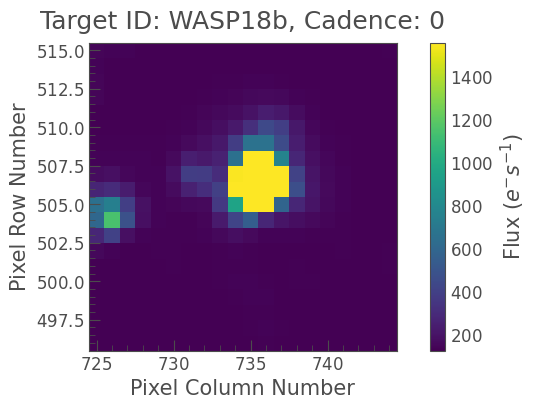

In [477]:
tpf_ = lk.search_tesscut(target).download(cutout_size=(20, 20))
tpf_.plot(); 

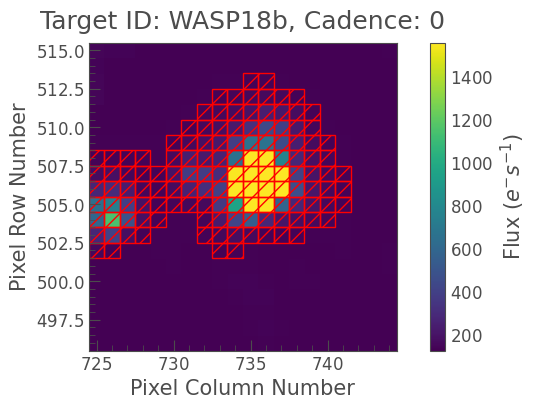

In [478]:
#we choose a really low threshold
aper_ = tpf_.create_threshold_mask(1)

tpf_.plot(aperture_mask=aper_);
plt.show()

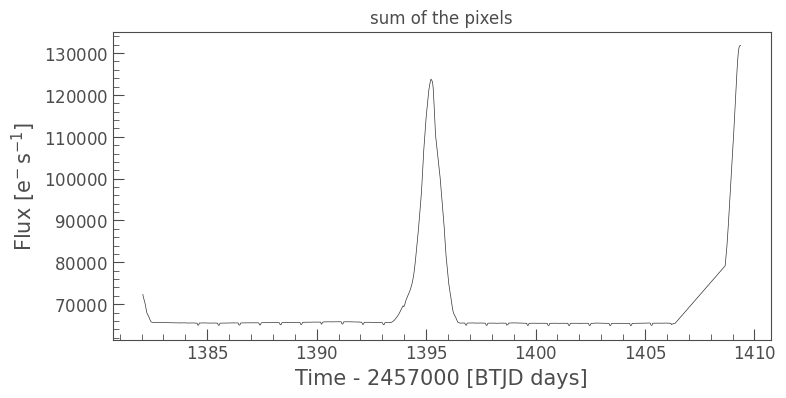

In [479]:
uncorrected_lc_ = tpf_.to_lightcurve(aperture_mask=aper_)
uncorrected_lc_.plot();
plt.title("sum of the pixels")
plt.show()

In [480]:
tpf_.animate() #to see a short animation of the planet

Now, we need to analize the best mask threshold. With that we dictaminate how similar we want the pixels to be around the one on reference.

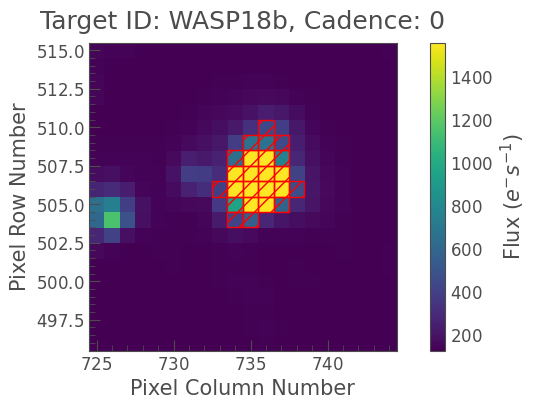

In [481]:
# and now with a higher one
aper = tpf_.create_threshold_mask(50)
tpf_.plot(aperture_mask=aper);
plt.show()

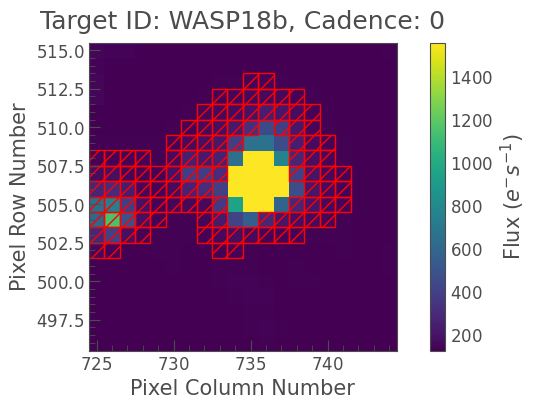

In [482]:
# Visualize outer region
outer_region = (tpf_.create_threshold_mask(threshold=1).astype(int) - aper.astype(int)).astype(bool)
tpf_.plot(aperture_mask=outer_region);

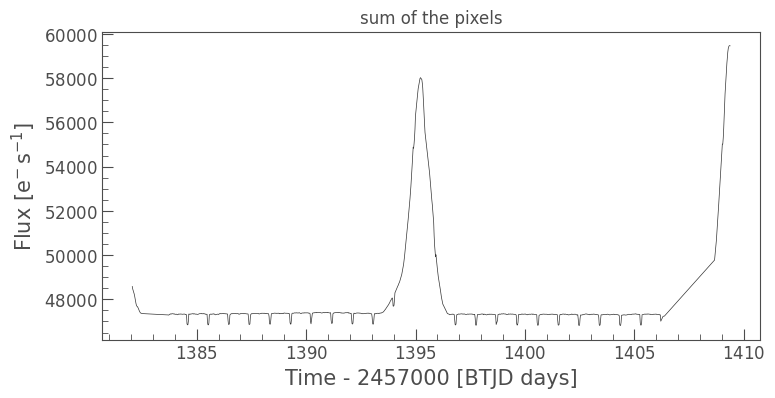

In [483]:
# Now we sum all those pixels
uncorrected_lc = tpf_.to_lightcurve(aperture_mask=aper)
uncorrected_lc.plot();
plt.title("sum of the pixels")
plt.show()

So if we compare the result of the sum of all the pixels inside the mask when we consider other object aside our planet, and only our planet, it's clear that the plots are highly different. In the first case, the magnitud in the axis y is different, it has a wider range, going from 75000 aprox up to 130000. Meanwhile, the second one only goes from 48000 reaching up to 60000 aproximately. This is because the other object adds light and alters the study of the real target. Having that on mind, we have to be precise and choose a mask that covers only the planet on study.

Then, I experimented with various thresholds values and conclude that the best was with 50. With that number we don't consider other objects and it is more precise to use a mask with 50 than 20 for example, so you consider more the planet's light and less of the "aura" around it.

Now, analizing this last plot, we can affirm that it is clearly the effect of scattered light. The main light sources that cause this effect are the moon and the earth. Also, we have to consider that the TESS orbits the earth twice in each sector and that makes the patterns appear twice in one sector, that's why we can see the scattered light effect almost two times in this plot. Also, the scattering lighting is very noticeable, so we can consider that it is really bad and it has to be corrected.

In order to remove that effect we can try and correct using the values of the pixels that are not associated with our aperture, those are the ones that are outside of it. 

### P1.2 PCA

PCA is a statistical technique used to simplify the complexity of sample spaces with a lot of dimensions. It reduces the dimensionality of them using linear algebra and conserves the information.
We will use this to reduce the amount of pixels we work with, with a lower amount of dimensions we can remove/mitigate the stochasting noise in the detrending vectors and the process will be faster, also if we stay with the principal components we can avoid pixels that have a significant inherent variability.

In [484]:
back = tpf_.flux[:, ~aper]
ntimes,npix=back.shape 
print('There are these many pixels %d in back, and %d times '%(npix, ntimes))

There are these many pixels 376 in back, and 1077 times 


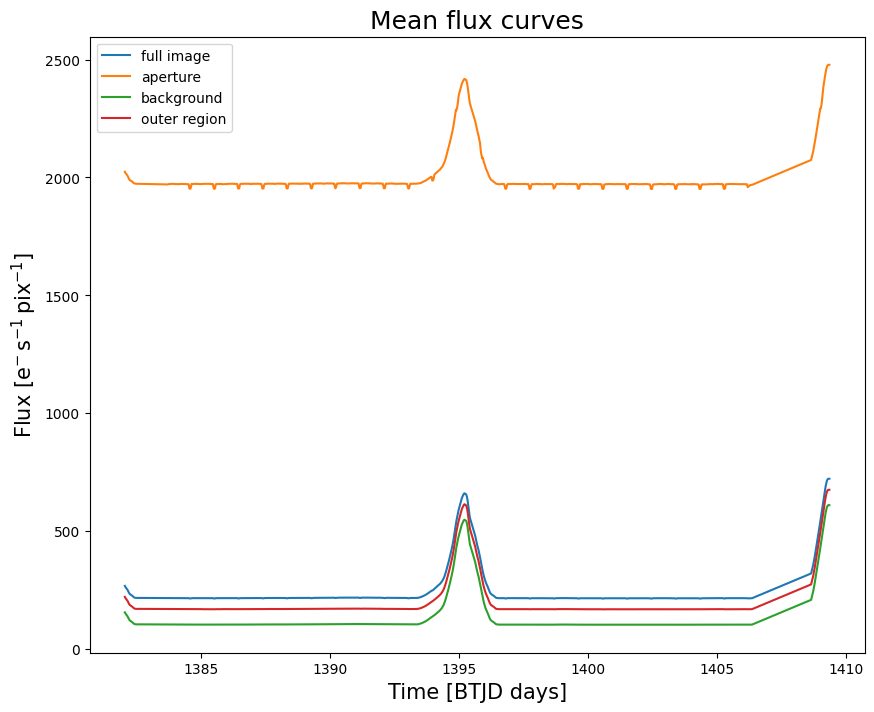

In [485]:
back2 = (tpf_.create_threshold_mask(threshold=-100).astype(int) - aper.astype(int)).astype(bool)

plt.figure(figsize=(10,8))
plt.title('Mean flux curves', fontsize=18)

# Visualize tpf flux [Full cut]:
plt.plot(tpf_.time.value, np.mean(tpf_.flux, axis=(1,2)), label='full image')

# Visualize tpf flux [aperture region]:
plt.plot(tpf_.time.value, np.mean(tpf_.flux[:, aper], axis=1), label='aperture')

# Visualize tpf flux [background]:
plt.plot(tpf_.time.value, np.mean(tpf_.flux[:, back2], axis=1), label='background')

# Visualize tpf flux [outer region]:
plt.plot(tpf_.time.value, np.mean(tpf_.flux[:, outer_region], axis=1), label='outer region')

plt.ylabel('Flux [$\\mathrm{e^{-}\\,s^{-1}\\,pix^{-1}}$]', fontsize=15)
plt.xlabel('Time [BTJD days]', fontsize=15)
plt.legend()
plt.show();

Here we have the visual description of the flux in different areas considerations.

In [486]:
dm = lk.correctors.DesignMatrix(back, name='back')
dm = dm.pca(3)#here we apply the PCA, it returns a new DesignMatrix with a smaller number of regressors, it reduces the number of columns.
dm

back DesignMatrix (1077, 3)

Now we will use RegressionCorrector to find the vectors that will make the light curve the closest to zero, with that we correct our problem of scattering light. This method corrects light curves by fitting and removing trends or systematic effects, it uses a linear regression model against a DesignMatrix to identify and correct those variations.

Text(0.5, 1.0, 'PCA correction')

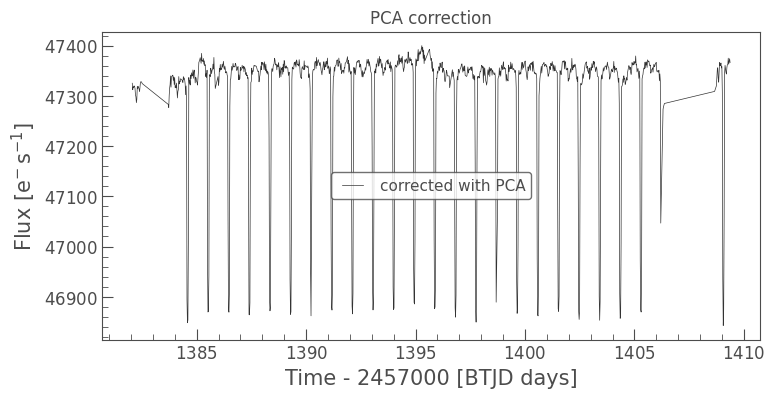

In [487]:
dm_ = dm.append_constant()
uncorrected1_lc = tpf_.to_lightcurve(aperture_mask=aper)
corrector = lk.correctors.RegressionCorrector(uncorrected1_lc)
corrected = corrector.correct(dm_)#we apply the correction to the light curve, it finds the best fit correction.
#let's plot the results
corrected.plot(label="corrected with PCA")
plt.title("PCA correction")

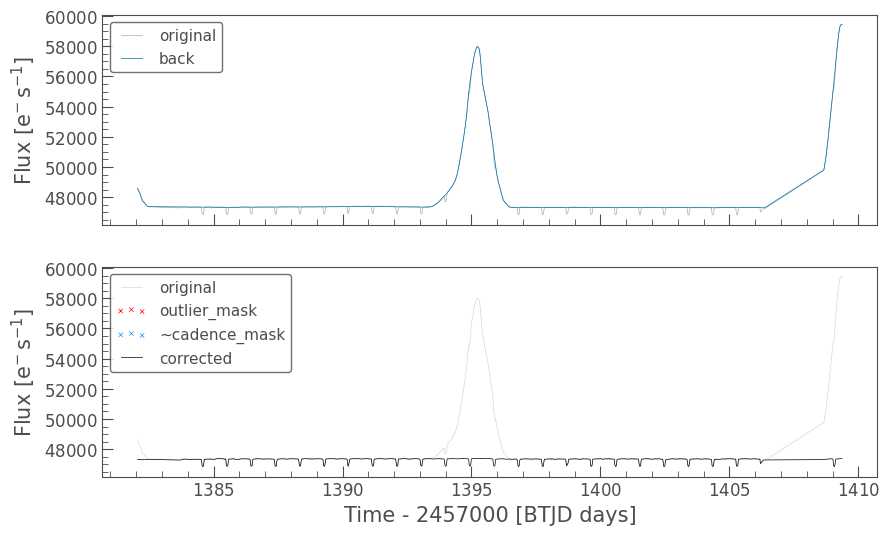

In [488]:
corrector.diagnose();

In this plot we have at the top the comparisson between the original curve and the back. We can notice that the background has the same peaks as the original, with that we can induce that the scattered light is added by the background.
Then, at the botton we have the corrected curve, it doesn't have abrupt peaks and all the transits are represented.

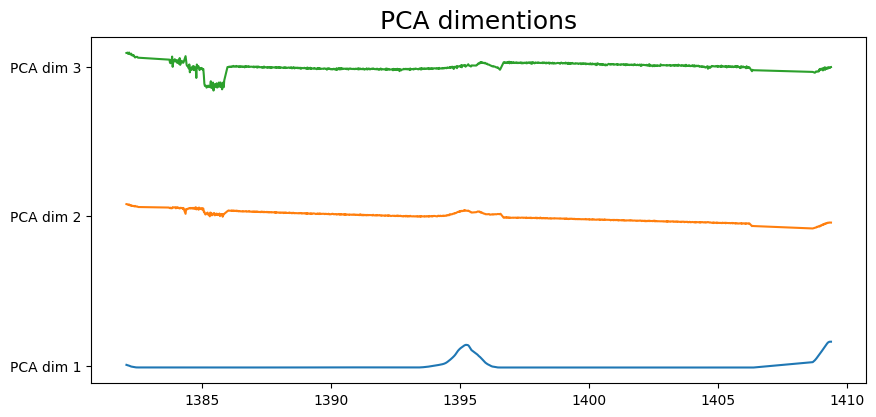

In [489]:
fig, ax = plt.subplots(figsize=(10, 1.5*3))

ax.plot(tpf_.time.value, dm.values + np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_yticklabels(['PCA dim %s' %i for i in range(1,3+1)])
ax.set_title('PCA dimentions', fontsize=18)

plt.show()

This is a visualization of the dimentions that we stayed with.



In this type of analisis we have some main sources of error such as the poor selection of the principal components. When we choose a bad number of principal components it can affect the quality of the correction. For example, if we use too much components, they can introduce noise and with not enough components, it can leave parts without the needed correction.
Also, there can be astrophysical signals that aren't well represented by the first principal components. They might be eliminated as it is interpreted as noise and proceed to be corrected.

In my case, I noticed that when I used 5 components instead of 3 components, the curves of the transitions where eliminated, so after trying different values, the one with only three gave me better results. 

## P1.3 Substract the outer region/background

In this method we take the light curve without corrections and we substract the median of the background multiplied by the number of pixels it has in its aperture

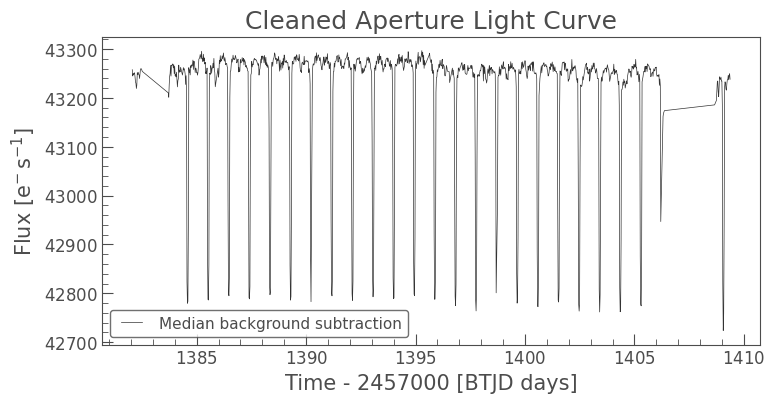

In [490]:
mean_subtracted_lc = uncorrected_lc - aper.sum()*np.mean(tpf_.flux[:, outer_region], axis=1)

mean_subtracted_lc.plot(label='Median background subtraction')
plt.title('Cleaned Aperture Light Curve', fontsize=18)
plt.show();

This method substracts the contribution of the backgroung in the aperture. In the plot of the back's light curve, we can notice that it's the same curve of the sum of pixels, but without the transits(analisis of this was made in the .diagnose of PCA). So that's why after applying this method and make the substrations, we correct the light curve.

To use this method we made the assumption that the background remains without major changes. If it has an object that moves and makes a significant change, it can provoke changes to the results of our correction, making it less precise. This can be considered a main source of error if not managed well.

## 2. Now we consider TESS' 2 minute cadence

In each TESS field a number of stars were designated as TESS Object of Interest, or TOI. Photometry from these were computed every 2 minutes and saved as a lightcurve, besides the Full Frame Images (FFI) that were accessed in part 1.

Let's fit a model for the transit.

In [491]:
# Download a 2-minute cadence Target Pixel File (TPF)
tpf_2min = lk.search_targetpixelfile(target, mission='TESS').download()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [492]:
# Use the pipeline aperture and an uncorrected light curve
# The aperture has already been computed and the lightcurve has been detrended
aper = tpf_2min.pipeline_mask
twomin_lc = tpf_2min.to_lightcurve()

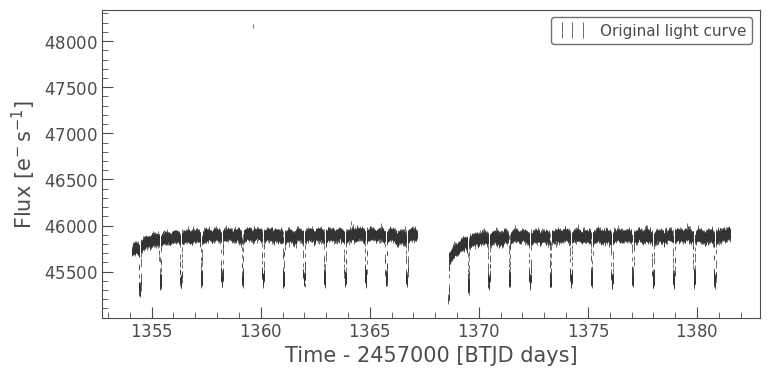

In [493]:
ax = twomin_lc.errorbar(label='Original light curve')

In [494]:

import numpy as np
def flux_at_time(t, F, Rp, Rs, c, t_ingress, t_duration):
    """
    Calculate the flux at a given time during the transit.
    Parameters:
    - t: current time
    - F: flux from the star out of transit
    - Rp: radius of the planet
    - Rs: radius of the star
    - c: linear limb-darkening coefficient
    - t_ingress: time of ingress
    - t_duration: full duration of the transit
    Returns:
    - F_t: flux at time t
    """
    t_med = t_ingress+t_duration/2.
    r = Rs*2*(t-t_med)/t_duration
    lambda_val = np.sqrt((Rs**2-r**2)/Rs**2)

    depth = (Rp / Rs)**2 * (1 + c * lambda_val)
    delta_F = F * depth
    t_egress = t_ingress + t_duration
    return np.where((t < t_ingress) | (t > t_egress), F, F - delta_F)#this part was change because it was provoking an error in the part of calculating the errors



/var/folders/ks/2w33drmj05d0pbd7pgzyfs8h0000gn/T/ipykernel_27991/2058661109.py:18: RuntimeWarning: invalid value encountered in sqrt
  lambda_val = np.sqrt((Rs**2-r**2)/Rs**2)


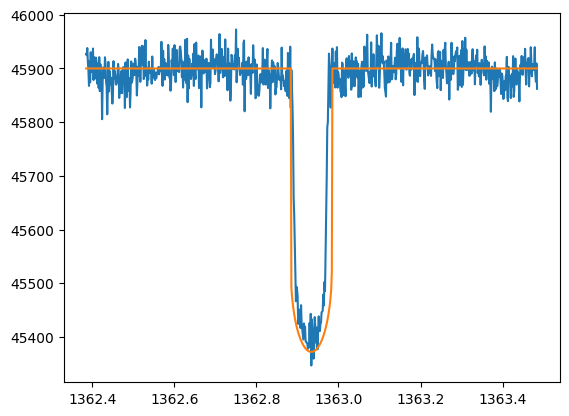

In [495]:
# ratio between Rp/Rs: 0.09

F, Rp, Rs, c, t_ingress, t_duration= 45900, 0.108, 1.2, 0.42, 1362.884, 0.1000
mod = [flux_at_time(t,F, Rp, Rs, c, t_ingress, t_duration) for t in twomin_lc['time'].btjd]

fig = plt.figure()
filt = (twomin_lc['time'].btjd>t_ingress-0.5) * (twomin_lc['time'].btjd<t_ingress+t_duration+0.5)
plt.plot(twomin_lc['time'].btjd[filt], twomin_lc['flux'][filt])
plt.plot(twomin_lc['time'].btjd[filt], np.array(mod)[filt])
plt.show()

Here we have our fit model. We can notice that it isn't perfect but it is really close to the original curve. Let's compute the uncertainties for the parameters we used.

In [496]:
#let's calculate the errors
from scipy.optimize import curve_fit
import numpy as np
params, covariance = curve_fit(flux_at_time,twomin_lc['time'].btjd[filt],twomin_lc['flux'][filt], p0 = [F, Rp, Rs, c, t_ingress, t_duration])
param_errors = np.sqrt(np.diag(covariance))
param_errors


/var/folders/ks/2w33drmj05d0pbd7pgzyfs8h0000gn/T/ipykernel_27991/2058661109.py:18: RuntimeWarning: invalid value encountered in sqrt
  lambda_val = np.sqrt((Rs**2-r**2)/Rs**2)


array([1.03290226e+00, 1.05102729e+03, 1.36765379e+04, 1.57135492e-01,
       9.94760895e-04, 1.12724943e-03])

/var/folders/ks/2w33drmj05d0pbd7pgzyfs8h0000gn/T/ipykernel_27991/2058661109.py:18: RuntimeWarning: invalid value encountered in sqrt
  lambda_val = np.sqrt((Rs**2-r**2)/Rs**2)


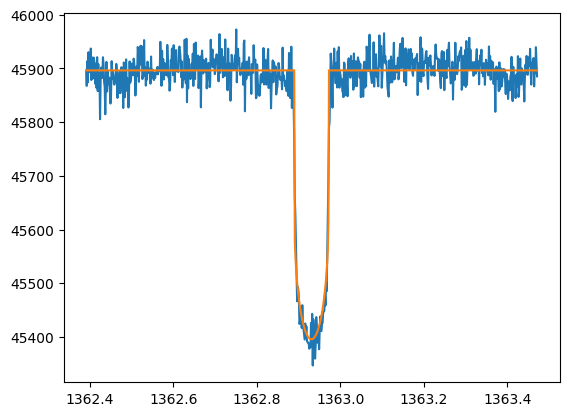

In [497]:
#now we plot with the parameters given by the covariance, this for comparing the plots.
F, Rp, Rs, c, t_ingress, t_duration = params
mod = [flux_at_time(t,F, Rp, Rs, c, t_ingress, t_duration) for t in twomin_lc['time'].btjd]
fig = plt.figure()
filt = (twomin_lc['time'].btjd>t_ingress-0.5) * (twomin_lc['time'].btjd<t_ingress+t_duration+0.5)
plt.plot(twomin_lc['time'].btjd[filt], twomin_lc['flux'][filt])
plt.plot(twomin_lc['time'].btjd[filt], np.array(mod)[filt])
plt.show()

We can see that there's a difference between both plots. Seeing the errors, we can conclude that the difference comes mainly from the radii. I calculated the radii with the ratio between Rp and Rs. Rp is: 0.09*(1.2R_sun) and Rs is 1.2 R_sun.

## Bibliography
- https://github.com/cefuente/astroinformatica/blob/main/HWK2%20-%20How%20big%20is%20your%20world.ipynb
- https://github.com/spacetelescope/mast_notebooks/blob/main/notebooks/TESS/removing_scattered_light_using_regression/removing_scattered_light_using_regression.ipynb this link was provided by the professor
- https://tess.mit.edu/publications/
- https://docs.lightkurve.org/reference/api/lightkurve.correctors.RegressionCorrector.html
- https://docs.lightkurve.org/reference/api/lightkurve.correctors.DesignMatrix.html#lightkurve.correctors.DesignMatrix
- https://docs.lightkurve.org/reference/api/lightkurve.correctors.RegressionCorrector.diagnose.html
- https://www.youtube.com/watch?v=3-AVQBtk5Qk